# Базовая случайная величина

БСВ – это непрерывная СВ равномерно распределённая на полуинтервале [0, 1) = R(0,1)

Программы для моделирвоания БСВ называются датчиками БСВ.
В основе программных БСВ лежат рекурентные формулы со стартовыми значениями.

$\alpha_t=\phi(\alpha_{t-1},...,\alpha_{t-p})$

Алгоримт деретменированный, но при правильной рекурентной фунции (преобразования) $\phi$ получаемые псевдослучайные величины по своим функциональным и числовым х-ками близки к БСВ.

Минус такого подхода: с некторого момента $t_0$ последовательность псевдо-БСВ образует цикл, повторяется бесконечное число раз. 
Длина последовательности $T$ называется периодом датчика БСВ.

Период $T$ и коэфф использования $k$ основными показателями качества датчика. Чем они больше, тем лучше.

In [332]:
print('hello')

hello


# Мультипликативный конгруэнтный метод

Псевдослучайная БСВ определяется как:

$\alpha_t = \alpha_t^{*} / M, \alpha_t^* = {\beta \alpha_{t-1}^*} mod M, t >= 1$

Где $\beta, M, \alpha_0^*$ -- параметры датчика (натуральные числа). $\alpha_0^*$ нечётное.

Показатели датчика $T <= M-1; k = 1$. 

Значения $\beta, \alpha_0^*$ определяются для максимизации  $T$

In [359]:
def mod(a, b):
    return a - b * (a//b)

def mult_congruent_bsv(alpha0=65539, beta=65539, M=2**31):
    print(f'alpha={alpha0} beta={beta}, M={M}')
    alpha = alpha0
    while(True):
        alpha = mod(beta * alpha, M)
        yield alpha / M

In [334]:
import itertools

first_ten = itertools.islice(mult_congruent_bsv(), 10)
print(list(first_ten))

[0.000488299410790205, 0.007538077887147665, 0.11346742464229465, 0.6762178777717054, 0.40567005751654506, 0.26660015201196074, 0.3733642320148647, 0.6520443423651159, 0.8545976909808815, 0.024046105798333883]


# Метод Маклорена-Марсали

Комбинирует два простейших датчика (например, мультипликативных конгруэнтных). 
Метод позволяет ослабить зависимость между членами случайно последовательности и сколь угодно увеличить $T$, 
при условии, что $T_1$ и $T_2$ взаимнопростые.

Пусть:
- ${\beta_t}, {c_t}$ -- исходные последовательности
- ${\alpha_t} -- результирующая БСВ
- $V = {V(0), V(1),..., V(K-1)} -- вспомогательная таблица $K$ чисел

Коэф использования = 1/2, а мне надо 1. Так что пока влом делать.

In [335]:
def macloren_marsali(bsv1, bsv2, K):
    pass

# Тесты проверки точности моделирования БСВ

Необходимо проверить гипотезу $H_0$: выборочные значения смоделированной величины являются реализациями
независимых СВ с распределнием $R(0,1)$

Три популярных специальных теста для этого:
1. "совпадение моментов"
2. "ковариация"
3. "равномерность двухмерного распределения"

In [371]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def read_generator(generator, skip=0, n=100):
    return np.array(list(itertools.islice(generator, skip, n + skip)))

def sovpadenie_momentov(bsv_generator, n, epsilon=0.95):
    exp_value = 1/2
    disp = 1/12
    
    c1 = lambda n: np.sqrt(12 * n)
    c2 = lambda n: (n-1) / n / np.sqrt(0.0056 / n + 0.0028 / n**2 - 0.0083 / n**3)
    delta = lambda e: norm.cdf(1 - e / 2)
    
    bsv = read_generator(bsv_generator, skip=100, n=n)
    
    m = np.mean(bsv)
    ss = np.mean((bsv[1:] - m)**2)
    
    xi1, xi2 = m - exp_value, ss - disp
    #print(np.abs(xi1), np.abs(xi2))
    
    D = delta(epsilon)
    #print(D)
    
    #print(c1(n) * np.abs(xi1), c2(n) * np.abs(xi2))
    return bsv, c1(n) * np.abs(xi1) < D and c2(n) * np.abs(xi2) < D


bsv, isOk = sovpadenie_momentov(mult_congruent_bsv(M=10**9 + 7), 1000)

alpha=65539 beta=65539, M=1000000007


# Короче я не шарю))

Но получилась какая-то лажа. БСВ становится лучше, если руками подбирать skip и n. Отстой какой-то.

Вот такие $a=b=65539, M=10^9 + 7$ дают мне норм 1000  БСВ


Построим теперь экспоненциальное распределение

In [337]:
def exp_distr(bsv, llambda):
    for a in bsv:
        x = -1 / llambda * np.log(a)
        yield x
        
        
def gamma_from_exp(exp, b, nu):
    exp = list(exp)
    while True:
        np.random.shuffle(exp)
        yield b * sum(exp[:nu])


def erlang_from_exp(exp, llambda, nu):
    return gamma_from_exp(exp, 1 / llambda, nu)

In [436]:
from scipy.stats import *
import matplotlib.pyplot as plt


def reflective_plotting(generatedVals, distribution_name, distribution=None):
    if not distribution:
        distribution = getattr(scipy.stats, distribution_name)
    
    rv = distribution
    x = np.linspace(rv.ppf(0.001),
                    rv.ppf(0.999), 100)
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, rv.pdf(x), 'r-', lw=2, label=distribution_name)

    ax.hist(generatedVals, density=True, 
            histtype='stepfilled', bins=30,
            alpha=0.2, label=f'my {len(generatedVals)} values')
    ax.legend(loc='best', frameon=False)
    plt.show()


def plot_my_uniform(bsv):
    reflective_plotting(bsv, 'uniform')


def plot_my_exp(expVals, llambda):
    reflective_plotting(expVals, 'exponential', expon(scale=1 / llambda))
    
    
def plot_erlang(erlang, llambda, nu):
    reflective_plotting(erlang, f'erlang({llambda}, {nu})', gamma(nu))

In [861]:
bsv_gen = mult_congruent_bsv(alpha0=65539,
                             beta=65539,
                             M=2**20)

ns = [50, 100, 500, 1000, 2000, 10000]
cache = { 'bsv': {}, 'exp': {} }


for n in ns:
    bsv = read_generator(bsv_gen, n=n)
    cache['bsv'][n] = bsv
    
    llambda = 1
    exp = read_generator(exp_distr(bsv, llambda), n=n)
    cache['exp'][n] = exp
    
for nu in [1, 2, 3]:
    if 'erlang' not in cache:
        cache['erlang'] = {}
    if nu not in cache['erlang']:
        cache['erlang'][nu] = {}
    for n in ns:
        exp = cache['exp'][n]
        erlang_gen = erlang_from_exp(exp, 1.0, nu)
        erlang = read_generator(erlang_gen, n=n)
        cache['erlang'][nu][n] = erlang

alpha=65539 beta=65539, M=1048576


n,Среднее значение,Дисперсия
50,0.4794,0.0866
100,0.4765,0.0789
500,0.5035,0.0816
1000,0.4955,0.0824
2000,0.4990,0.0822
10000,0.4993,0.0840
идеал,0.5000,0.0833


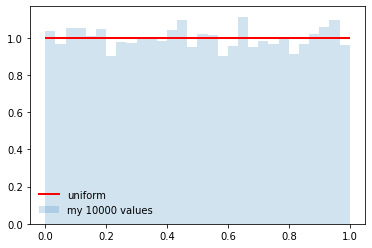

n,Среднее значение,Дисперсия
50,1.0989,1.1757
100,1.1331,1.6691
500,0.9752,0.9187
1000,1.0232,1.0839
2000,0.9988,0.9798
10000,1.0024,0.9906
идеал,1.0000,1.0000


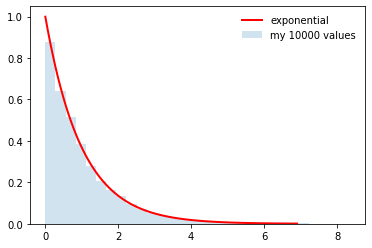

n,Среднее значение,Дисперсия
50,1.2468,1.3506
100,1.1507,1.7444
500,0.9457,0.8447
1000,1.0154,1.0765
2000,0.9734,0.9264
10000,1.0088,1.0057
идеал,1.0000,1.0000


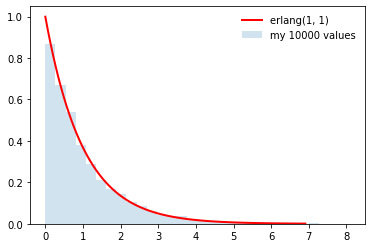

n,Среднее значение,Дисперсия
50,2.2371,1.6289
100,2.1862,4.1103
500,1.9952,1.9115
1000,2.0645,2.2078
2000,2.0286,2.0628
10000,2.0168,2.0172
идеал,2.0000,2.0000


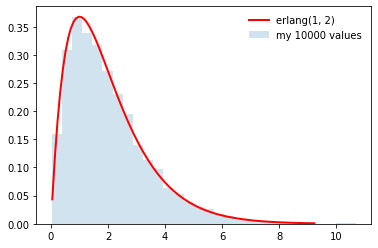

n,Среднее значение,Дисперсия
50,3.5530,2.9977
100,3.4321,5.0056
500,2.9390,2.8646
1000,3.0082,3.4170
2000,2.9600,2.8354
10000,2.9957,2.9583
идеал,3.0000,3.0000


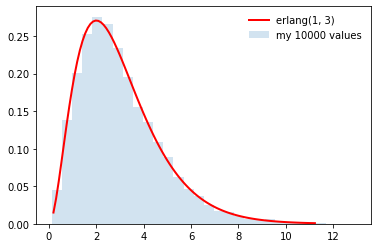

In [862]:
from IPython.display import HTML, display
import tabulate

def stats(values):
    m = np.mean(values)
    std = np.mean((values - m)**2)
    return m, std


def apply_formatting(frmt, row):
    return list(map(lambda t: t[0].format(t[-1]),
             zip(frmt, row)))

def stats_tables(cache):
    head = ['n', "Среднее значение", "Дисперсия"]
    frmt = ['{:-d}'] + ['{:.4f}'] * 2
    
    def one_table(val_dict, m, std):
        table = [head]
        
        for n, vals in val_dict.items():    
            row = [n, *stats(vals)]
            frmt_row = apply_formatting(frmt, row)
            table.append(frmt_row)
            
        table.append(apply_formatting(
            ['{:s}'] + frmt[1:],
            ['идеал', m, std]
        ))
        
        display(HTML(tabulate.tabulate(table, tablefmt='html')))
      
    one_table(cache['bsv'], 0.5, 1/12)
    plot_my_uniform(cache['bsv'][ns[-1]])
    
    one_table(cache['exp'], 1/llambda, 1/llambda**2)
    plot_my_exp(cache['exp'][ns[-1]], llambda)
        
    for nu in [1, 2, 3]:
        b = 1 / llambda
        m = nu * b
        std = nu * b**2
        
        erlang_vals = cache['erlang'][nu]
        one_table(erlang_vals, m, std)
        plot_erlang(erlang_vals[ns[-1]], llambda, nu)

stats_tables(cache)

alpha=65539 beta=65539, M=1048576


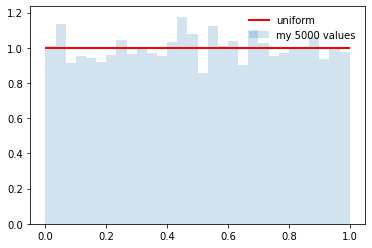

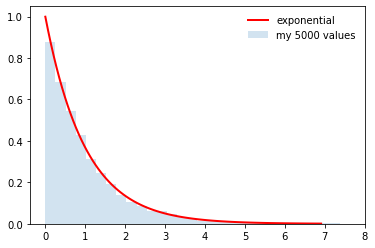

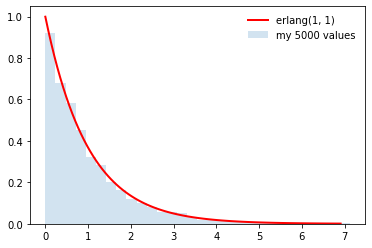

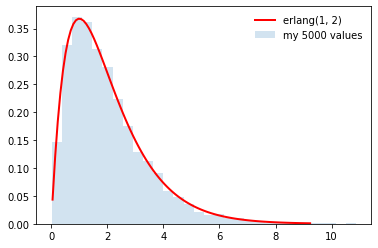

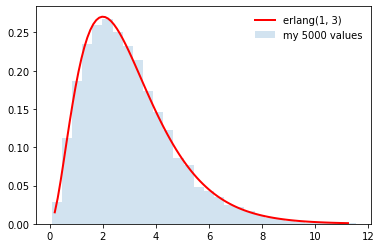

In [441]:


bsv_gen = mult_congruent_bsv(alpha0=65539,
                             beta=65539,
                             M=2**20)

bsv = read_generator(bsv_gen, skip=100, n=5000)


exp = read_generator(exp_distr(bsv, llambda), n=5000)

plot_my_uniform(bsv)
plot_my_exp(exp, llambda)

for nu in range(1, 4):
    erlang = read_generator(erlang_from_exp(expVals, llambda, nu), n=5000)
    plot_erlang(erlang, llambda, nu)

#bsv, isOk = sovpadenie_momentov(bsv_gen, 5000)
#print('isOk:', isOk)





# Резко перескочу к третьей лабе.


у меня двойной интеграл. Из него можно вытянуть

$p_\eta(x,y)  = k_x * k_y * e^{-(x^2 + y^2) / 2}$ на интервале $(2, 4) \times (3, + \infty)$.

Это представим как две независимые СВ, которые можно моделировать отдельно.

1) $p_{\eta_1}(x)  = k_x e^{-x^2 / 2}$ на $(2, 4)$

2) $p_{\eta_2}(y)  = k_y e^{-y^2 / 2}$ на $(3, \times)$

$p_{\eta_1}$ на $(2, 4)$ выглядит как обрезанный кусочек нормально распределения.
По идее, если домножить на подходящий коэф, то покатит.

Как выбарть правильные распределения мне пока не ясно.

## Равномерное + Экспоненциальное


$p_y(x) = 1 / 2$

$p_x(x) = \lambda * e^{-\lambda x}$ 

пусть $\lambda = ???$, а к случайной величине добавлю 3 чтобы сдвинуть вправо.


Не вышло

In [769]:
def gen_y(n):
    return np.random.uniform(2, 4, n)
    
    
def gen_x(n, llambda):
    return expon.rvs(loc=3,scale=1/llambda, size=n)


def gen_pairs(n, llambda):
    return zip(gen_x(n, llambda), gen_y(n))


def targetRv(n, llambda=1.0):
    g = lambda x,y: np.exp(-0.5 * (x**2 + y**2)) * np.log(1 + (x / y)**2)
    p = lambda x,y: 0.5 * llambda * np.exp(-llambda * x)
    for x, y in gen_pairs(n, llambda):
        yield g(x,y) / p(x,y)
        
    
n = 10000
llambda = 1.0
targetRv = np.fromiter(targetRv(n, llambda), np.float64)
ans = targetRv.mean()
ans

0.004153597316020354

Ок, так не работает. Попробую равномерное и halfnormal (нормальное > 0)

$p_y(x) = 1 / 2$

$p_x(x) = \sqrt{2 / \pi} * e^{-(x)^2 / 2}$ 

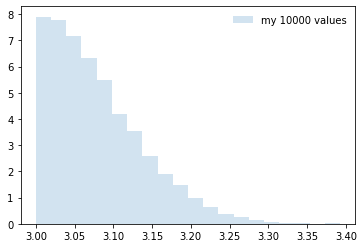

In [941]:
def plotHists(vals):
    fig, ax = plt.subplots(1, 1)

    ax.hist(vals, density=True, 
            histtype='stepfilled', bins=20,
            alpha=0.2, label=f'my {len(vals)} values')
    ax.legend(loc='best', frameon=False)
    plt.show()

plotHists(halfnorm.rvs(loc=3, scale=1/10,size=10000))

In [880]:
def gen_y(n):
    return uniform.rvs(2, 2, n)
    
    
def gen_x(n):
    return halfnorm.rvs(size=n)


def gen_pairs(n):
    return zip(gen_x(n), gen_y(n))


def gen_xi(n):
    g = lambda x,y: np.exp(-0.5 * (x**2 + y**2)) * np.log(1 + (x / y)**2)
    p = lambda x,y: 0.5 * np.sqrt(2 / np.pi) * np.exp(-0.5 * (x**2))
    for x, y in gen_pairs(n):
        yield g(x+3,y) / p(x,y)
  

In [936]:
def calc_stats(values):
    mean = np.mean(values)
    std_dev = np.mean((values - mean)**2)
    exp_err = 0.6745 * np.sqrt(std_dev / len(values))
    exp_err = 3 * np.sqrt(std_dev / len(values))
    return mean, std_dev, exp_err


def do_calc(n):
    values = np.fromiter(gen_xi(n), np.float64)
    return calc_stats(values)


def experimetns_as_table(ns=[10, 20, 50, 100, 1000, 10000], attempts=5):
    head = ['эксперимент', 'n', 'Ответ', 'Дисперсия', 'Вероятная ошибка']
    frmt = ['{:d}'] * 2 + ['{:.9f}'] * 3

    table = []
    for n in ns:
        table.append(head)
        anss = []
        for attempt in range(attempts): # 10 tries per n
            ans, std, err = do_calc(n)
            row = [attempt + 1, n, ans, std, err]
            frmt_row = apply_formatting(frmt, row)
            table.append(frmt_row)
            anss.append(ans)
        
        summary = ['', 'попыток', 'Среднее значение']
        summary_row = apply_formatting(
            [''] + frmt[1:],
            ['', attempts, np.array(anss).mean()]
        )
        table.append(summary)
        table.append(summary_row)

    display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [937]:
experimetns_as_table()

эксперимент,n,Ответ,Дисперсия,Вероятная ошибка
1,10,0.000257927,0.000000154,0.000372729
2,10,0.000107584,0.000000018,0.000126090
3,10,0.000128975,0.000000095,0.000292433
4,10,0.000223525,0.000000138,0.000353043
5,10,0.000277906,0.000000201,0.000425016
,попыток,Среднее значение,,
,5,0.000199183,,
эксперимент,n,Ответ,Дисперсия,Вероятная ошибка
1,20,0.000049309,0.000000006,0.000052292
2,20,0.000156848,0.000000099,0.000210545


In [885]:
do_calc(1000000)

(0.00021010552373773128, 0.20031021154139522, 0.0003018794143665822)

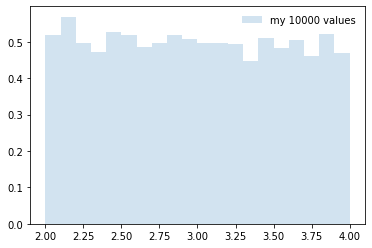

In [879]:
plotHists(uniform.rvs(2,2,10000))

In [893]:
def gen_eta_2(n):
    k = halfnorm.cdf(4) - halfnorm.cdf(2)
    kInv = 1 / k
    
    count = 0
    generated = 0
    for r in range(10000):
        size = int(kInv * (n - count))
        generated += size
        for rv in halfnorm.rvs(size=size):
            if count == n:
                return
            if 2 <= rv <= 4:
                count += 1
                yield rv

 
def gen_eta_1(n):
    k = 1 - halfnorm.cdf(3)
    kInv = 1 / k
    
    count = 0
    generated = 0 
    for r in range(10000):
        size = int(kInv * (n - count))
        generated += size
        for rv in halfnorm.rvs(size=size):
            if count == n:
                return
            if rv >= 3:
                count += 1
                yield rv

In [899]:
sample_size = 100
k1 = halfnorm.cdf(4) - halfnorm.cdf(2)
k2 = 1 - halfnorm.cdf(3) 
sample = np.array([2 / np.pi * np.log( 1 + (eta2 / eta1)**2 ) 
          for eta1, eta2 in zip(gen_eta_1(sample_size), gen_eta_2(sample_size))])

sample = k1 * k2 * sample

def calc_stats(values):
    mean = np.mean(values)
    std_dev = np.mean((values - m)**2)
    exp_err = 0.6745 * np.sqrt(std_dev / n)
    return mean, std_dev, exp_err

calc_stats(sample)

(3.194616149185896e-05, 0.20046949625506097, 0.00301999416288532)

In [891]:
k1 = halfnorm.cdf(4) - halfnorm.cdf(2)
k2 = 1 - halfnorm.cdf(3) 
k1 * k2 * sample.mean()

4.026103904665498e-09

In [689]:
sample.mean()

0.409120203888782

In [567]:
k1 * k2

0.00012267042155664974

Ок, раз уж не работает, попробую пример с хабра
    
   